In [19]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

In [28]:
# Data Loading
resize_to = (28, 28)
data = []
labels = []
file_name = []

dataset_dir = "dataset"
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Folder '{dataset_dir}' tidak ditemukan di direktori kerja saat ini: {os.getcwd()}")

for sub_folder in os.listdir(dataset_dir):
    sub_folder_path = os.path.join(dataset_dir, sub_folder)
    if not os.path.isdir(sub_folder_path):
        continue  # Lewati file yang bukan folder
    sub_folder_files = os.listdir(sub_folder_path)
    for filename in sub_folder_files:
        img_path = os.path.join(sub_folder_path, filename)
        img = cv.imread(img_path)
        if img is None:
            print(f"Gagal membaca: {img_path}")
            continue
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, resize_to)
        data.append(img)
        labels.append(sub_folder)
        file_name.append(filename)

data = np.array(data)
labels = np.array(labels)

In [35]:
# Define Preprocessing Function
def threshold(image):
    img = image.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] >= 85:
                img[i][j] = 255
            else: 
                img[i][j] = 0
    return img

def prewitt_edge(image):
    kernelx = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
    kernely = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    img_prewittx = cv.filter2D(image, -1, kernelx)
    img_prewitty = cv.filter2D(image, -1, kernely)
    prewitt = cv.addWeighted(img_prewittx, 0.5, img_prewitty, 0.5, 0)
    return prewitt

In [34]:
# Preprocessing
dataPreprocessed = []
for i in range(len(data)):
    img = threshold(data[i])
    img = prewitt_edge(img)
    dataPreprocessed.append(img)

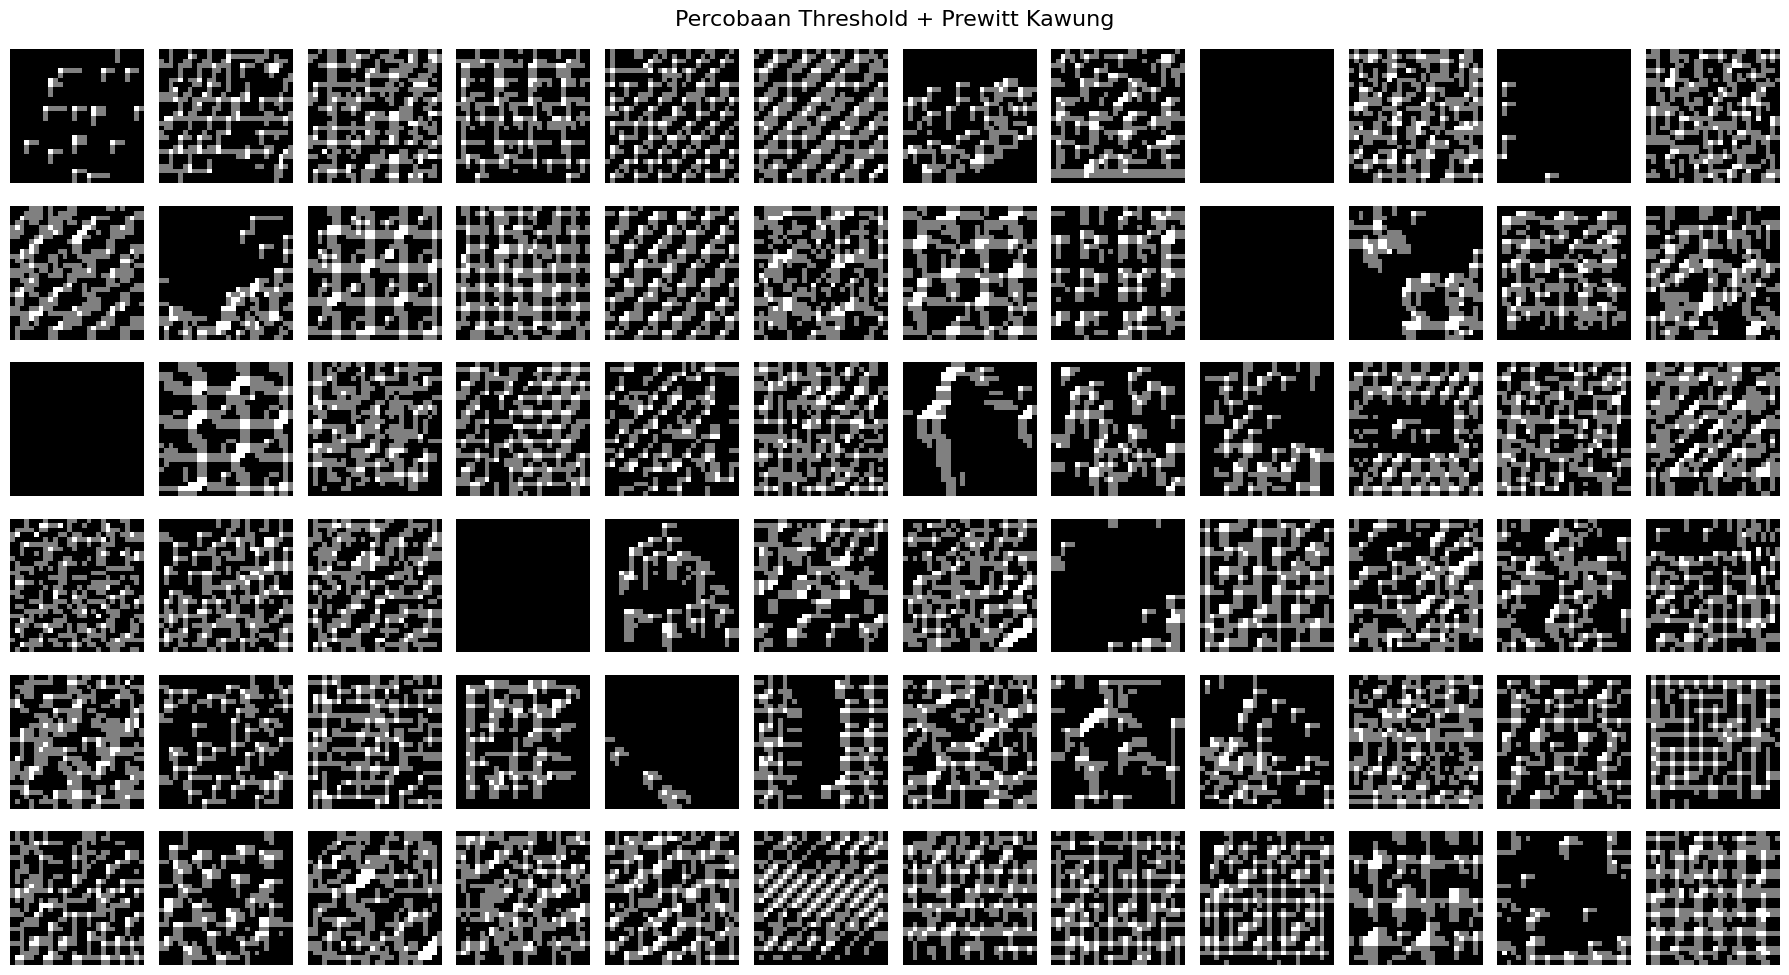

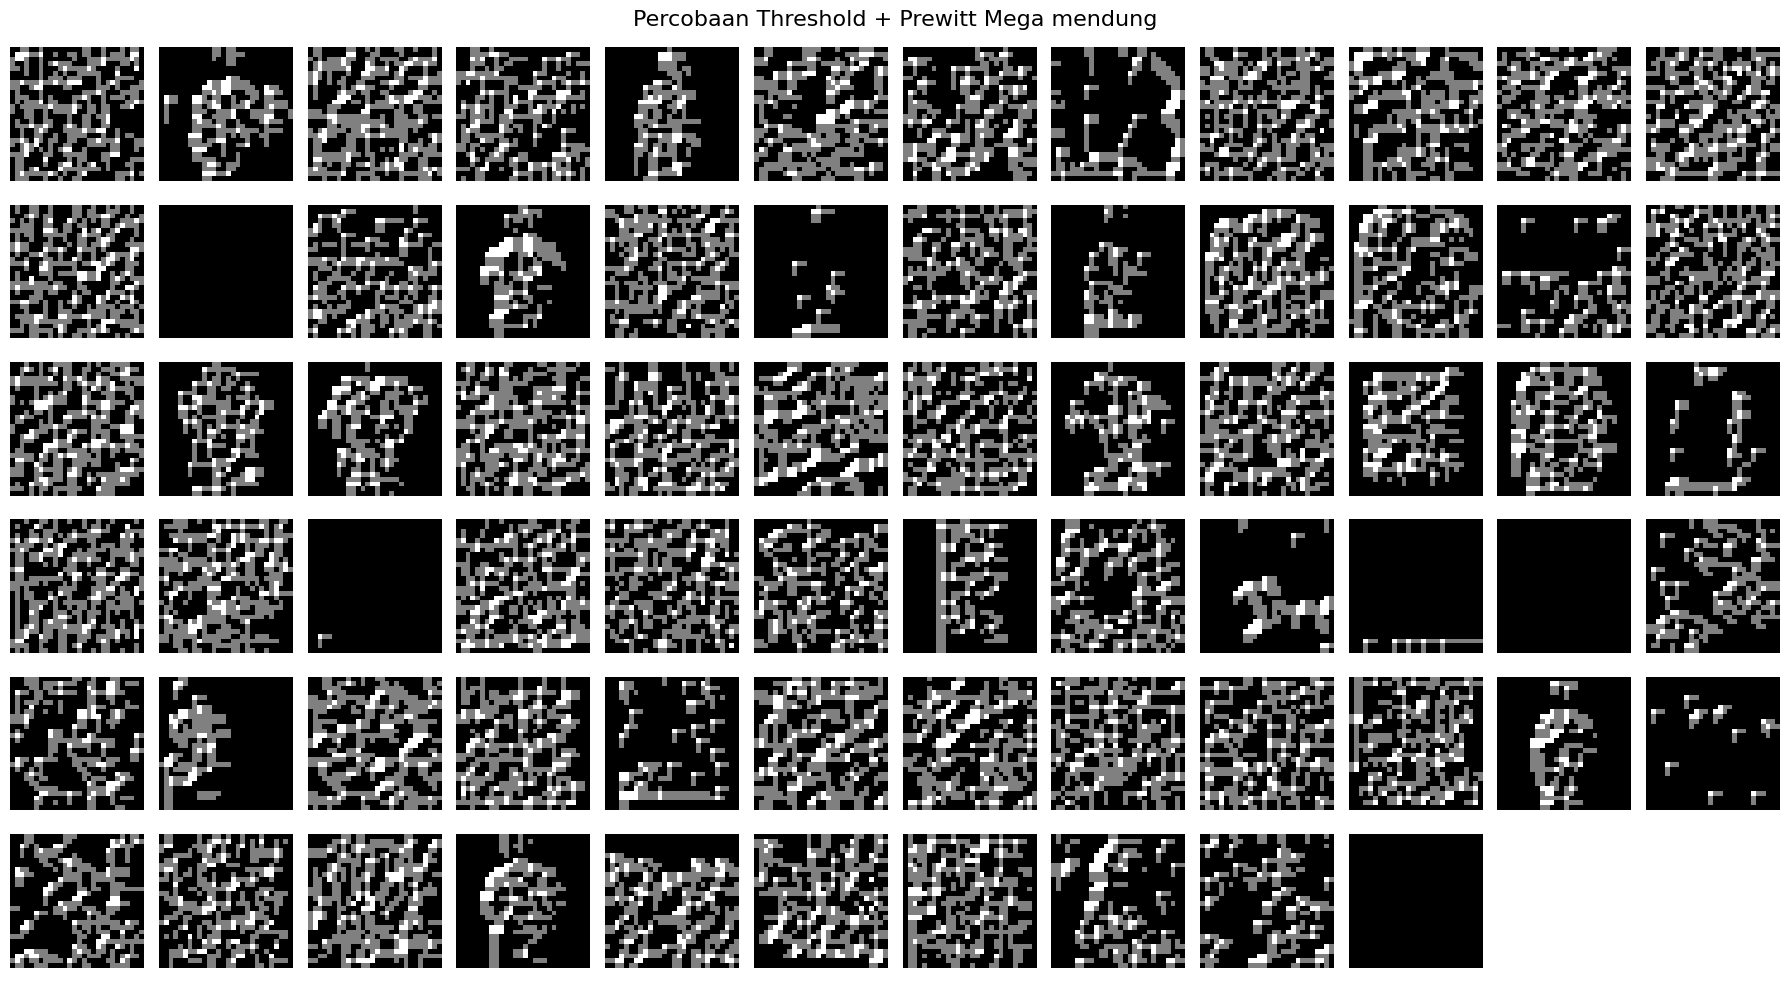

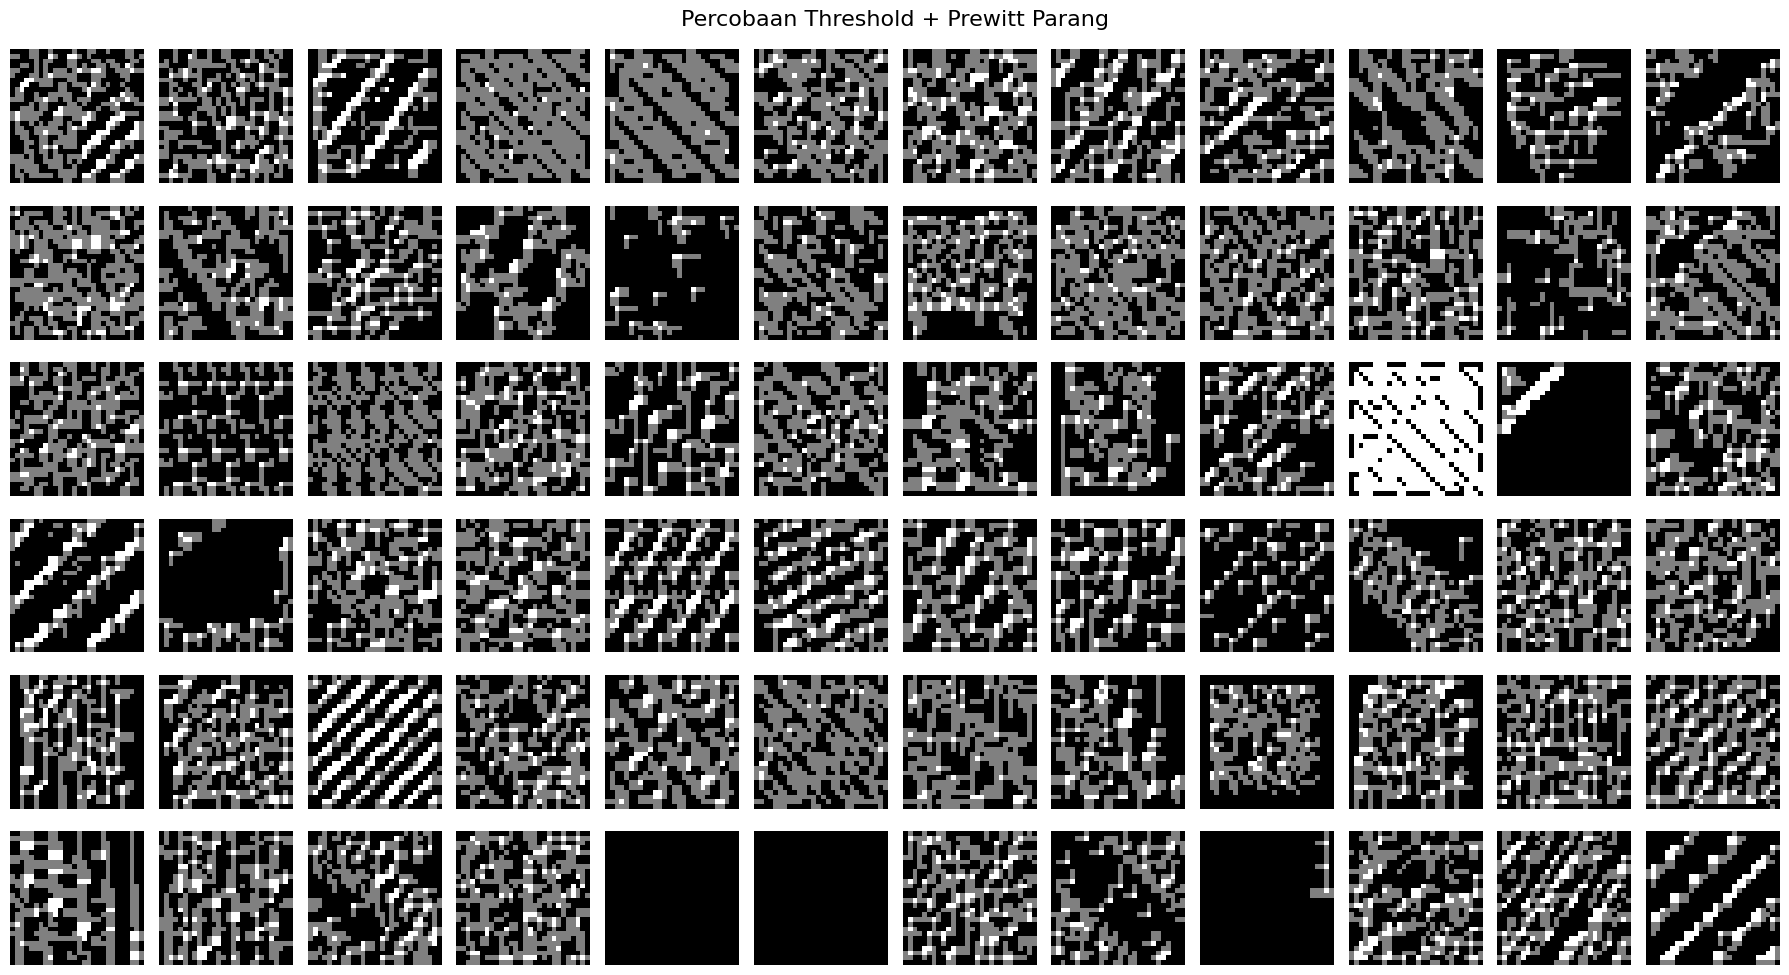

In [38]:
# Visualisasi hasil preprocessing
unique_labels = sorted(set(labels))

for label in unique_labels:
    idxs = [j for j, l in enumerate(labels) if l == label]
    fig, axs = plt.subplots(6, 12, figsize=(18, 10))
    fig.suptitle(f'Percobaan Threshold + Prewitt {label}', fontsize=16)
    total = min(len(idxs), 72)  # hanya tampilkan sebanyak gambar yang ada atau maksimal 72
    for k in range(72):
        row = k // 12
        col = k % 12
        ax = axs[row][col]
        if k < total:
            ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')
    plt.tight_layout()

In [39]:
# Feature Extraction
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [40]:
def correlation(matriks):
    return graycoprops(matriks, 'correlation')[0, 0]

In [41]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [42]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [43]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [44]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [45]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [46]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [47]:
Derajat0, Derajat45, Derajat90, Derajat135 = [], [], [], []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [48]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [49]:
for i in range(len(dataPreprocessed)):
    correlation0.append(correlation(Derajat0[i]))
    correlation45.append(correlation(Derajat45[i]))
    correlation90.append(correlation(Derajat90[i]))
    correlation135.append(correlation(Derajat135[i]))

In [50]:
for i in range(len(dataPreprocessed)):
    Kontras0.append(contrast(Derajat0[i]))
    Kontras45.append(contrast(Derajat45[i]))
    Kontras90.append(contrast(Derajat90[i]))
    Kontras135.append(contrast(Derajat135[i]))

In [51]:
for i in range(len(dataPreprocessed)):
    dissimilarity0.append(dissimilarity(Derajat0[i]))
    dissimilarity45.append(dissimilarity(Derajat45[i]))
    dissimilarity90.append(dissimilarity(Derajat90[i]))
    dissimilarity135.append(dissimilarity(Derajat135[i]))

In [52]:
for i in range(len(dataPreprocessed)):
    homogenity0.append(homogenity(Derajat0[i]))
    homogenity45.append(homogenity(Derajat45[i]))
    homogenity90.append(homogenity(Derajat90[i]))
    homogenity135.append(homogenity(Derajat135[i]))

In [53]:
for i in range(len(dataPreprocessed)):
    entropy0.append(entropyGlcm(Derajat0[i]))
    entropy45.append(entropyGlcm(Derajat45[i]))
    entropy90.append(entropyGlcm(Derajat90[i]))
    entropy135.append(entropyGlcm(Derajat135[i]))

In [54]:
for i in range(len(dataPreprocessed)):
    ASM0.append(ASM(Derajat0[i]))
    ASM45.append(ASM(Derajat45[i]))
    ASM90.append(ASM(Derajat90[i]))
    ASM135.append(ASM(Derajat135[i]))

In [55]:
for i in range(len(dataPreprocessed)):
    energy0.append(energy(Derajat0[i]))
    energy45.append(energy(Derajat45[i]))
    energy90.append(energy(Derajat90[i]))
    energy135.append(energy(Derajat135[i]))

In [56]:
# Write the extraction's results to CSV 
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_threshold_prewitt.csv', index=False)
hasilEkstrak = pd.read_csv('hasil_ekstraksi_threshold_prewitt.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,megamendung.84.jpg,Mega mendung,10117.896825,14853.086420,9811.783069,12528.353909,0.502674,0.401952,0.544999,0.437617,...,0.201483,0.183702,0.441468,0.424613,0.448869,0.428605,0.246785,-0.093369,0.269975,0.077760
1,megamendung.90.jpg,Mega mendung,5777.357143,8494.474623,5516.624339,8046.389575,0.744723,0.655711,0.744723,0.658455,...,0.398345,0.346653,0.623933,0.583549,0.631146,0.588772,0.518351,0.305777,0.539203,0.342398
2,megamendung.53.jpg,Mega mendung,9850.071429,15336.320988,9724.431217,11715.780521,0.530450,0.412925,0.518546,0.454077,...,0.179263,0.168148,0.425580,0.406103,0.423394,0.410059,0.319645,-0.049975,0.327619,0.197899
3,megamendung.91.jpg,Mega mendung,10606.550265,15877.456790,9918.801587,13193.478738,0.531772,0.392350,0.514578,0.454076,...,0.207746,0.187089,0.453447,0.425580,0.455792,0.432538,0.260255,-0.093175,0.308458,0.091619
4,megamendung.85.jpg,Mega mendung,4399.470899,7019.201646,4353.089947,5812.589849,0.793662,0.725666,0.800276,0.733897,...,0.478130,0.431911,0.682429,0.646533,0.691469,0.657199,0.580090,0.344858,0.583173,0.457478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,kawung.41.jpg,Kawung,8646.931217,13365.212620,8517.576720,11404.979424,0.505321,0.496597,0.505321,0.485625,...,0.192378,0.178036,0.438194,0.421171,0.438609,0.421943,0.390962,0.067261,0.399615,0.204063
291,kawung.54.jpg,Kawung,10005.825397,15925.903978,10613.650794,14178.850480,0.513255,0.389606,0.480189,0.434872,...,0.195912,0.181437,0.448130,0.424978,0.442619,0.425954,0.277764,-0.136003,0.233891,-0.011385
292,kawung.68.jpg,Kawung,10345.142857,17931.100137,10481.928571,12925.536351,0.531772,0.356685,0.500028,0.458191,...,0.184716,0.172681,0.435268,0.409003,0.429786,0.415548,0.308076,-0.186531,0.298927,0.144695
293,kawung.83.jpg,Kawung,4404.531746,6112.096022,3255.923280,5841.703704,0.789694,0.744870,0.843924,0.753100,...,0.568554,0.490372,0.718275,0.693893,0.754025,0.700266,0.422334,0.207177,0.565578,0.242250


<Axes: >

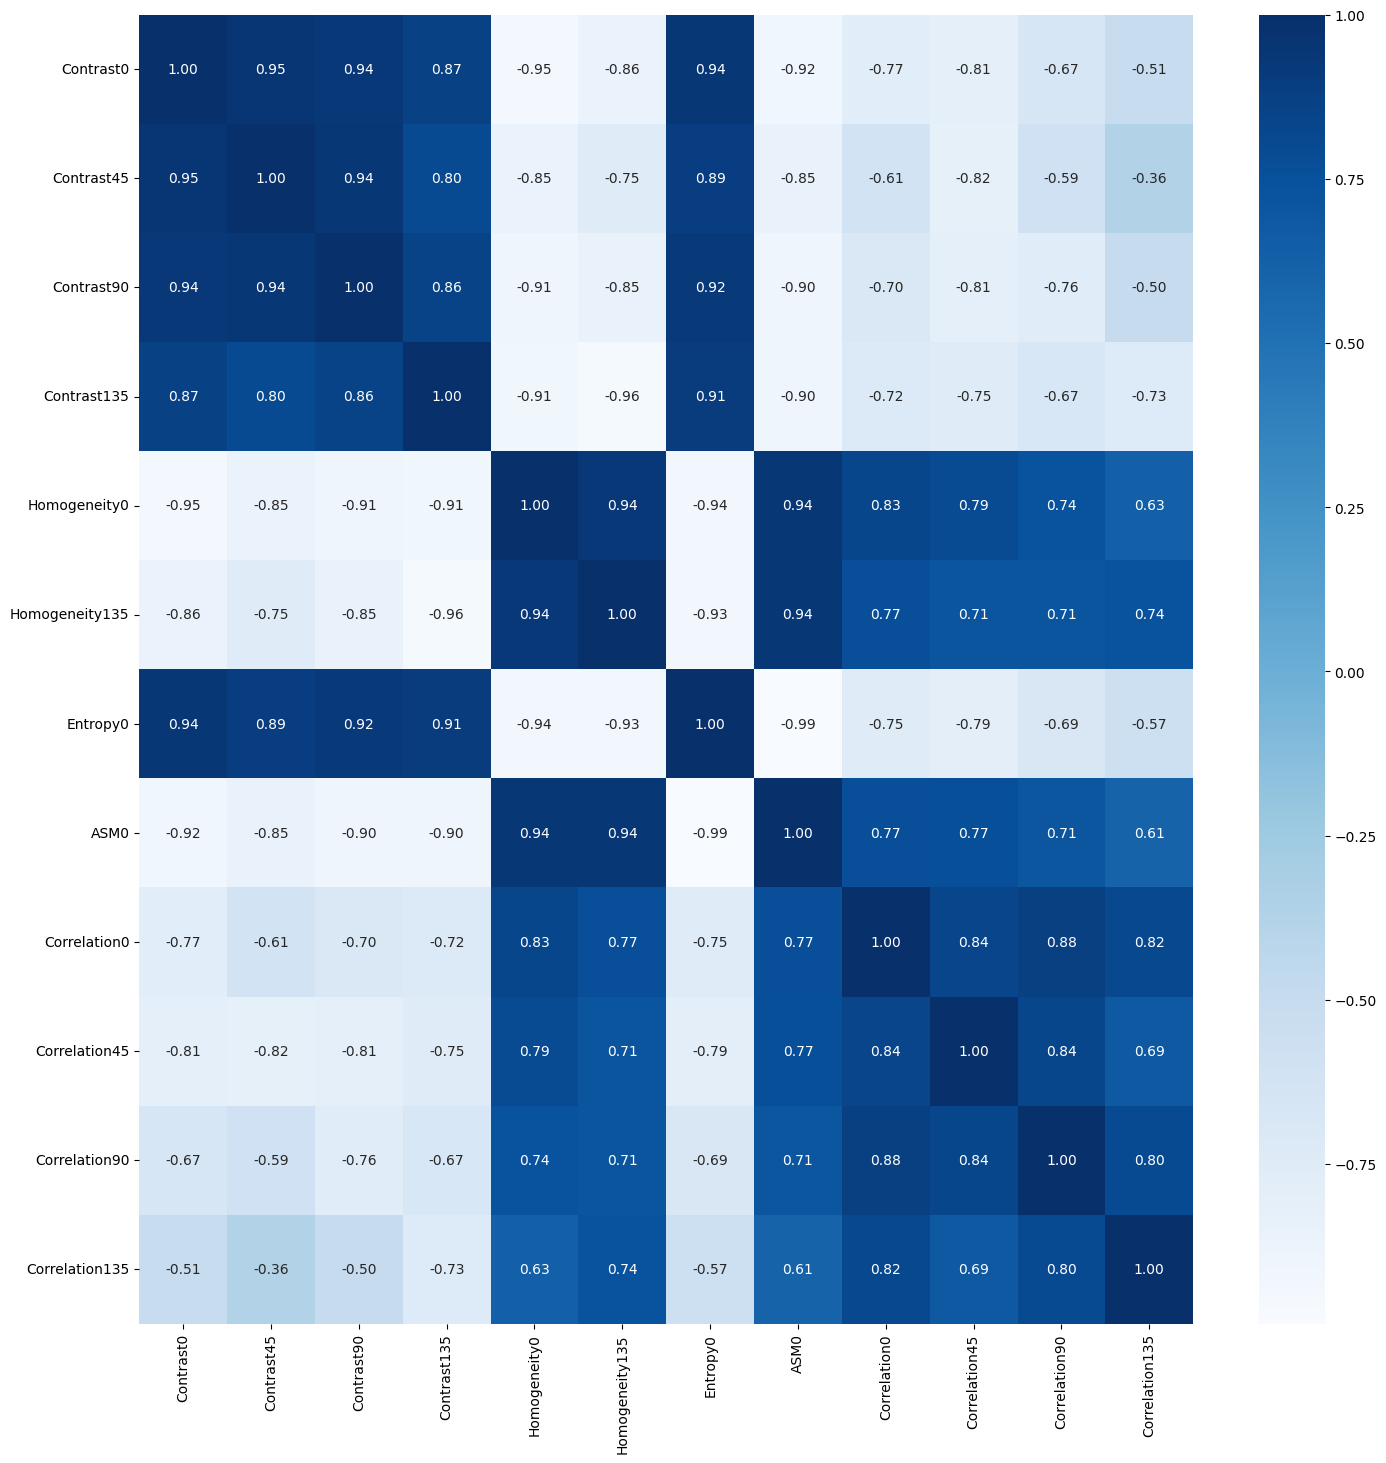

In [57]:
# Features Selection (Correlation)
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()
threshold = 0.95
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
    for j in range(i+1, correlation.shape[0]):
        if correlation.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

In [58]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(236, 12)
(59, 12)


In [59]:
# Feature Normalization (Standardization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [60]:
# Modeling
def generateClassificationReport(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print('Accuracy:', accuracy_score(y_true, y_pred))

rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [61]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

      Kawung       0.91      0.94      0.93        88
Mega mendung       0.94      0.91      0.93        56
      Parang       0.91      0.90      0.91        92

    accuracy                           0.92       236
   macro avg       0.92      0.92      0.92       236
weighted avg       0.92      0.92      0.92       236

[[83  1  4]
 [ 1 51  4]
 [ 7  2 83]]
Accuracy: 0.9194915254237288

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.54      0.70      0.61        20
Mega mendung       0.58      0.50      0.54        14
      Parang       0.67      0.56      0.61        25

    accuracy                           0.59        59
   macro avg       0.60      0.59      0.59        59
weighted avg       0.60      0.59      0.59        59

[[14  0  6]
 [ 6  7  1]
 [ 6  5 14]]
Accuracy: 0.5932203389830508


In [62]:
# Train SVM Classifier
svm.fit(X_train, y_train)
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

      Kawung       0.51      0.69      0.59        88
Mega mendung       0.56      0.16      0.25        56
      Parang       0.66      0.72      0.69        92

    accuracy                           0.58       236
   macro avg       0.58      0.52      0.51       236
weighted avg       0.58      0.58      0.55       236

[[61  6 21]
 [34  9 13]
 [25  1 66]]
Accuracy: 0.576271186440678

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.32      0.35      0.33        20
Mega mendung       0.00      0.00      0.00        14
      Parang       0.51      0.72      0.60        25

    accuracy                           0.42        59
   macro avg       0.28      0.36      0.31        59
weighted avg       0.33      0.42      0.37        59

[[ 7  0 13]
 [10  0  4]
 [ 5  2 18]]
Accuracy: 0.423728813559322


In [63]:
# Train KNN Classifier
knn.fit(X_train, y_train)
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

      Kawung       0.63      0.76      0.69        88
Mega mendung       0.55      0.71      0.62        56
      Parang       0.82      0.51      0.63        92

    accuracy                           0.65       236
   macro avg       0.67      0.66      0.65       236
weighted avg       0.69      0.65      0.65       236

[[67 14  7]
 [13 40  3]
 [26 19 47]]
Accuracy: 0.652542372881356

------Testing Set------
              precision    recall  f1-score   support

      Kawung       0.48      0.70      0.57        20
Mega mendung       0.36      0.36      0.36        14
      Parang       0.88      0.56      0.68        25

    accuracy                           0.56        59
   macro avg       0.57      0.54      0.54        59
weighted avg       0.62      0.56      0.57        59

[[14  4  2]
 [ 9  5  0]
 [ 6  5 14]]
Accuracy: 0.559322033898305


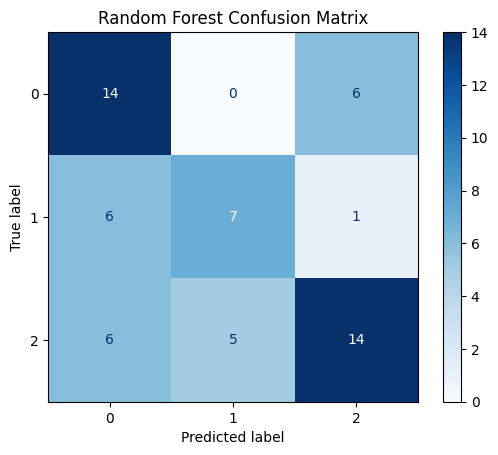

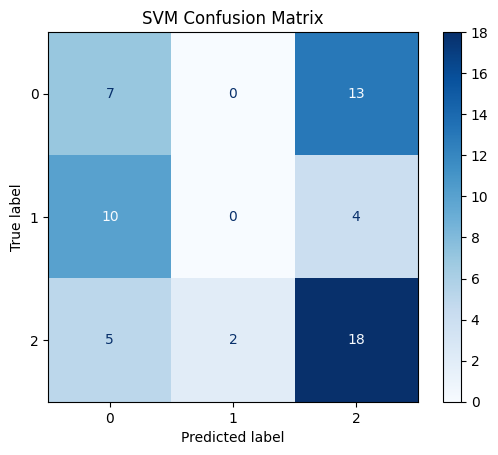

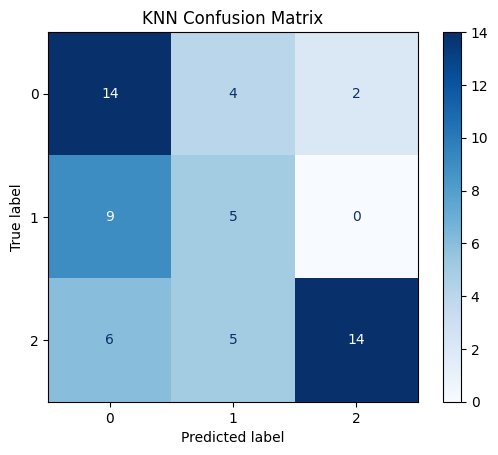

In [64]:
# Evaluation With Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")

In [ ]:
``